In [1]:
!pip install git+https://github.com/aVariengien/self-organized-control.git#subdirectory=code
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym[box2d] pyvirtualdisplay > /dev/null 2>&1

  Cloning https://github.com/aVariengien/self-organized-control.git to /tmp/pip-req-build-l6n8k6_e
  Running command git clone -q https://github.com/aVariengien/self-organized-control.git /tmp/pip-req-build-l6n8k6_e
  Created wheel for SelfOrgControl: filename=SelfOrgControl-0.1-py3-none-any.whl size=27287 sha256=2a9137b72c83d8fca7ae9cbd88dc0759fa437109541b47fe72f12ebbd2b81c27
  Stored in directory: /tmp/pip-ephem-wheel-cache-wiqzowil/wheels/fb/6c/e6/2b2782038124f63bd884ecb8afb16c794d6b42f5d636de0c28
Successfully built SelfOrgControl


In [2]:
!pip install Box2D

     |████████████████████████████████| 1.3 MB 5.0 MB/s 


In [3]:
import tensorflow as tf
import numpy as np
import time
import SelfOrgControl.NeuralCA as NCA
from SelfOrgControl.NeuralCAVisu import visualize_agent, show_influence_field
import gym
import matplotlib.pyplot as plt

In [4]:
#Start a virtual display to be able to render the cart-pole environment in Colab
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [36]:
#print(gym.envs.registry.all())

env = gym.make("MountainCar-v0")
env.seed(0)

[0]

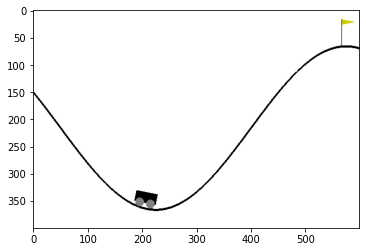

In [37]:
env.reset()
img = env.render(mode='rgb_array')

plt.imshow(img)
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())
ipythondisplay.clear_output(wait=True)

In [39]:
print(env)

<TimeLimit<MountainCarEnv<MountainCar-v0>>>


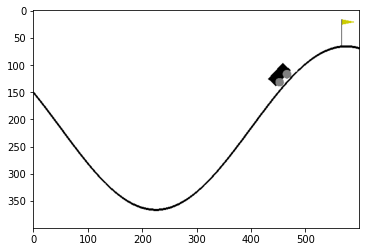

In [44]:
# Testing adjustment of the state
env.env.state = np.array([0.2, 1])

img = env.render(mode='rgb_array')

plt.imshow(img)
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())
ipythondisplay.clear_output(wait=True)

# 1. Defining Grid parameters

Similar to [TODO] we use a 32x32 Cellular Automata grid. The state $x_t$ of the environment at timestep $t$ is an 8-dimensional real-valued vector containing:
- X distance from target site (Cont.)
- Y distance from target site (Cont.)
- X velocity (Cont.)
- Y velocity (Cont.)
- Angle of ship (Cont.)
- Angular velocity of ship (Cont.)
- Left leg is grounded (Bin.)
- Right leg is grounded (Bin.)

Each dimension of the state space is encoded through two separate input cells.

The action space $A$ is a Discrete 1-Dimensional space with 4 possible values:
- Do Nothing
- Fire Left orientation engine
- Fire Right orientation engine
- Fire Main engine

The probability of choosing action $a_i$ for $i=1,2,3,4$ is encoded through dedicated output cells. 

In [14]:
# Confirm the dimensionality of the input space
print(env.observation_space.shape)
# Confirm dimensionality of the action space
print(env.action_space)

(8,)
Discrete(4)


In [15]:
inp_cell_pos = [(11, 26),(25,20), # X Dist. Target
                (5,20),(19,6),    # Y Dist. Target
                (19,26),(5,12),   # X Vel.
                (25,12) ,(11, 6), # Y Vel.
                (15, 26), (15, 6), # Angle
                (5, 16), (25, 6), # Angular Vel.
                (8, 23), (22, 23), # Left Leg Grounded
                (8, 9), (22, 9)] # Right Leg Grounded

out_cell_pos = [(13,14), # Expected reward 'Do Nothing'
                (17,14), # Expected reward 'Fire Left orientation engine'
                (13,18), # Expected reward 'Fire right orientation engine'
                (17,18)] # Expected reward 'Fire main engine'


In [32]:

#@title DQN Definition
import os

import random
import gym
import numpy as np
import tensorflow as tf
from collections import deque
from SelfOrgControl.NeuralCA import *
from IPython import display as ipythondisplay

# The original structure of the code was taken from
#  https://github.com/pythonlessons/Reinforcement_Learning/tree/master/01_CartPole-reinforcement-learning



class DQNAgent:
    def __init__(self, inp_cell_pos, out_cell_pos, cyclic_boundary=False, auto_reset = False,
                        show_arrows=True):
        self.env = gym.make("LunarLander-v2")
        self.env.seed(0)

        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 1000000
        self.max_len_memory = 50000

        self.memory = deque(maxlen=self.max_len_memory)

        self.use_batch_training = True

        self.gamma = 0.95    # discount rate
        self.epsilon = 1. # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.batch_size = 128
        self.train_start = 1000 #number of environment step before begin of the
                                #training
        self.nb_replay = 0

        self.in_factors = np.array([2., 0.25, 4., 0.15])
        self.out_factor = 0.01

        self.file_name= "lunarlander-dqn-NeuralCA_replay_"

        self.cur_state = None #for step by step test to create visualisation

        # create main model
        lr = 5e-3
        lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            [1000,10000], [lr, lr*0.1, lr*0.001])

        self.model = TrainableNeuralCA(input_electrodes = inp_cell_pos,
                                    output_electrodes = out_cell_pos,
                                    grid_size=32,
                                    batch_size=16, channel_n=6,
                                    ca_steps_per_sample=(50,60),
                                    replace_proba=0.01,
                                    task_loss_w=0.5, grid_pool_size=100,
                                    learning_rate=lr,
                                    repeat_input=2,torus_boundaries=False,
                                    penalize_overflow=True, overflow_w = 1e2,
                                    use_hidden_inputs=True, perturb_io_pos=True,
                                    add_noise=False, damage=True,
                                    nb_hid_range=(0,0), move_rad=0, proba_move=0.0)

        #the pool of cart-pole states
        self.lander_states = [ self.env.reset() for k in range(10)]
        self.max_env_it = 2

        self.longest_run = 0
        self.losses = []
        self.best_model_name = ""



    def remember(self, state, action, reward, next_state, done):
        experience = {"state":state, "action": action, "reward": reward,
                     "next_state":next_state, "done":done }

        self.memory.append(experience)

        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state*self.in_factors))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory

        minibatch = random.choices(self.memory, k=min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i]["state"]
            action.append(minibatch[i]["action"])
            reward.append(minibatch[i]["reward"])
            next_state[i] = minibatch[i]["next_state"]
            done.append(minibatch[i]["done"])

        predictions = self.model.predict(state*self.in_factors, use_batch=True)/ self.out_factor
        target = predictions.copy()
        target_next = self.model.predict(next_state*self.in_factors, use_batch=True)/ self.out_factor


        for i in range(self.batch_size):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # Q_max = max_a' Q_target(s', a')
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))


        # We divide the batch of experiences of size self.batch_size in
        # self.batch_size//self.model.batch_size smaller batch of
        # size self.model.batch_size (the batch size of the neural CA)

        if self.use_batch_training:
            state = np.reshape(state, (self.batch_size//self.model.batch_size,
                                self.model.batch_size, self.state_size) )

            target = np.reshape(target, (self.batch_size//self.model.batch_size,
                                        self.model.batch_size, 2) )

        # we scale the inputs and outputs according to the predefined factors
        state = state*self.in_factors
        target = target*self.out_factor

        loss = self.model.fit(state, target, verbose=False,
                        use_batch=self.use_batch_training)
        self.losses.append(loss)

        if self.nb_replay%10 == 0:

            sc,_, nb_t,_ = self.test(render=False, verbose=False)
            if self.longest_run < nb_t:
                filename_save = self.file_name+str(self.nb_replay)+"_score_"+\
                                str(np.round(sc,4))+"_"+str(nb_t) +"_it"
                self.best_model_name = filename_save
                print("New high score, model saved to "+filename_save)
                self.model.neuralCA.dmodel.save_weights(filename_save)
                self.longest_run = nb_t

            print(("\rReplay #%.i | Epsilon: %.3f | log10 loss: %.2f " +\
                    "| Test score: %.2f | Test duration: %.i | Best duration: %.i        ")%(self.nb_replay,
                                                                self.epsilon,
                                                                 np.log10(np.mean(self.losses)),
                                                                  sc, nb_t, self.longest_run),
                                                                  end='')
            self.losses = []

        self.EPISODES -= 1
        self.nb_replay +=1

    def load(self, name):
        self.model.load(name)

    def save(self, name):
        self.model.save(name)

    def run(self):
        """Run the training process of the DQN agent"""
        while self.EPISODES>0:

            # Sampling from the pool of cart-pole states
            rd_id = random.randint(0,len(self.lander_states)-1)
            state= self.lander_states[rd_id]
            self.env.reset()
            self.env.set_state(state)
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            tot_score = 0

            # K iteration of the environment
            while not done and i<self.max_env_it:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                tot_score += reward
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            if done:
                self.lander_states[rd_id] = np.squeeze(self.env.reset())
            else:
                self.lander_states[rd_id] = np.squeeze(state)

            self.replay()



    def test_one_step(self, render=True, fix_nb_step=-1, conti_damage_proba=None):
        """Advance the test of the DQN agent of one step and return the
            frame."""
        if self.cur_state is None:
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            self.cur_state = state
        if self.cur_state == "END":
            return self.prev_img



        if conti_damage_proba is not None:
            pred, _ = self.model.predict(self.cur_state*self.in_factors,
                        conti_damage_proba=conti_damage_proba,
                        return_all_grids=True, no_reinit=True)
        else:
            pred = self.model.predict(self.cur_state*self.in_factors,
                        conti_damage_proba=conti_damage_proba,
                        return_all_grids=False)

        action = np.argmax(pred)

        next_state, reward, done, _ = self.env.step(action)
        state = np.reshape(next_state, [1, self.state_size])
        self.cur_state = state
        if done:
            self.cur_state = "END"

        if render:
            img = self.env.render(mode="rgb_array")
            self.prev_img = img

        return img

    def test(self, render=True, nb_episode=1, fix_nb_step=-1,
                random_action_proba=False, verbose=1,
                conti_damage_proba=None, return_sensors=False,
                render_for_colab=False):
        """Test the agent for nb_episodes runs. Returns the mean and standard
            deviation of the lengths of the episodes and the score.
            verbose -- 0: no information printed
                       1: results of each episode printed
                       2: action and observation at each step of the episode

            fix_nb_step -- If different of -1, this value is used to fix a limit
                            of the lengths of the simulations.

            random_action_proba -- The proba of taking a random action at each
                                    step

            conti_damage_proba -- If not none, this value is used as the proba of
                                    damaging the grid at each step
            return_sensors -- Whether to return the list of observations"""

        if verbose>0:
            print("----------------- Begin testing -----------------")
        ACTIONS = ["left", "right"]
        S = []
        mean_it = []
        sensors = []
        for e in range(nb_episode):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            tot_score = 0

            while ((not done and fix_nb_step ==-1) or
                  (i<fix_nb_step and fix_nb_step !=-1)):
                if render:
                    self.env.render()
                if render_for_colab:
                    screen = self.env.render(mode='rgb_array')
                    plt.imshow(screen)
                    plt.axis("off")
                    ipythondisplay.clear_output(wait=True)
                    ipythondisplay.display(plt.gcf())

                if conti_damage_proba is not None:
                    pred, _ = self.model.predict(state*self.in_factors,
                                conti_damage_proba=conti_damage_proba,
                                return_all_grids=True, no_reinit=True)
                else:
                    pred = self.model.predict(state*self.in_factors,
                                conti_damage_proba=conti_damage_proba,
                                return_all_grids=False)
                action = np.argmax(pred)
                if verbose == 2:
                    print(ACTIONS[action])
                    print(pred/self.out_factor)
                    print(state*self.in_factors)

                if random_action_proba is not None:
                    if np.random.random() < random_action_proba:
                        action=np.random.randint(0,2)

                next_state, reward, done, _ = self.env.step(action)
                if return_sensors:
                    sensors.append(next_state*self.in_factors)
                tot_score += reward
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done and fix_nb_step==-1 and verbose>0:
                    print("Test #{}, score: {:.5}, duration: {}".format(e, tot_score,i))
            S.append(tot_score)
            mean_it.append(i)
        self.env.close()
        if return_sensors:
            return np.mean(S),np.std(S), np.mean(mean_it), np.std(mean_it), sensors
        else:
            return np.mean(S),np.std(S), np.mean(mean_it), np.std(mean_it)




# Model Initialisation

The model is trained through a simplistic form of colloquium training. To initialize the weights, the neural CA is trained to compute the mean of the received inputs

In [28]:
lr = 5e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [1000, 5000], [lr, lr*0.1, lr*0.001])

nca = NCA.TrainableNeuralCA(input_electrodes = inp_cell_pos,
                            output_electrodes = out_cell_pos,
                            grid_size=32,
                            batch_size=16, channel_n=6,
                            ca_steps_per_sample=(50,60),
                            replace_proba=0.01,
                            task_loss_w=0.5, grid_pool_size=100,
                            learning_rate=lr,
                            repeat_input=1, #there is no redondancy
                            torus_boundaries=False,
                            penalize_overflow=True, overflow_w = 1e2,
                            use_hidden_inputs=True, perturb_io_pos=True,
                            add_noise=False, damage=True,
                            nb_hid_range=(0,0), move_rad=0, proba_move=0.0)
print(nca.neuralCA.dmodel.summary())

inputs_b = (np.random.random((4000,16,16)) - 0.5)*2
targets_b = np.repeat(np.expand_dims(np.mean(inputs_b, axis=-1),-1),4,axis=-1)*4
#we add a factor 4 to get on average a greater amplitude in the output values to
# predict


nca.fit(inputs_b, targets_b, verbose=True, use_batch=True)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (16, 32, 32, 20)          1100      
                                                                 
 conv2d_10 (Conv2D)          (16, 32, 32, 30)          630       
                                                                 
 conv2d_11 (Conv2D)          (16, 32, 32, 6)           186       
                                                                 
Total params: 1,916
Trainable params: 1,916
Non-trainable params: 0
_________________________________________________________________
None
Training ...
 Training: 99.75 % | Time per sample: 0.101s | log10 of loss: -0.553    Training end in 386.269s. Mean log 10 loss: 0.864


7.3179701019926

In [26]:
inputs_b = (np.random.random((4000,16,8)) - 0.5)*2
print(inputs_b.shape)

targets_b.shape

inputs_b[:, :, 6:].shape

(4000, 16, 8)


(4000, 16, 2)

In [ ]:
#np.random.randint(0, 1, size=())

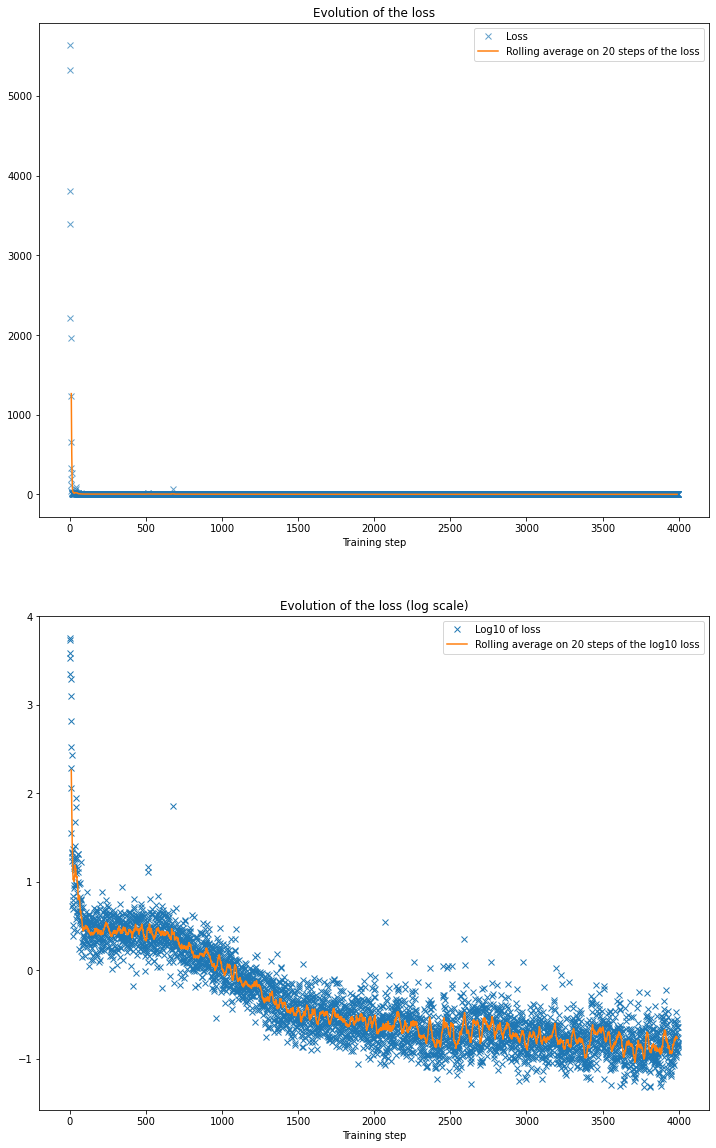

In [29]:
nca.plot_losses() #plot the loss curve

/usr/local/lib/python3.7/dist-packages/SelfOrgControl/NeuralCA.py:660: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


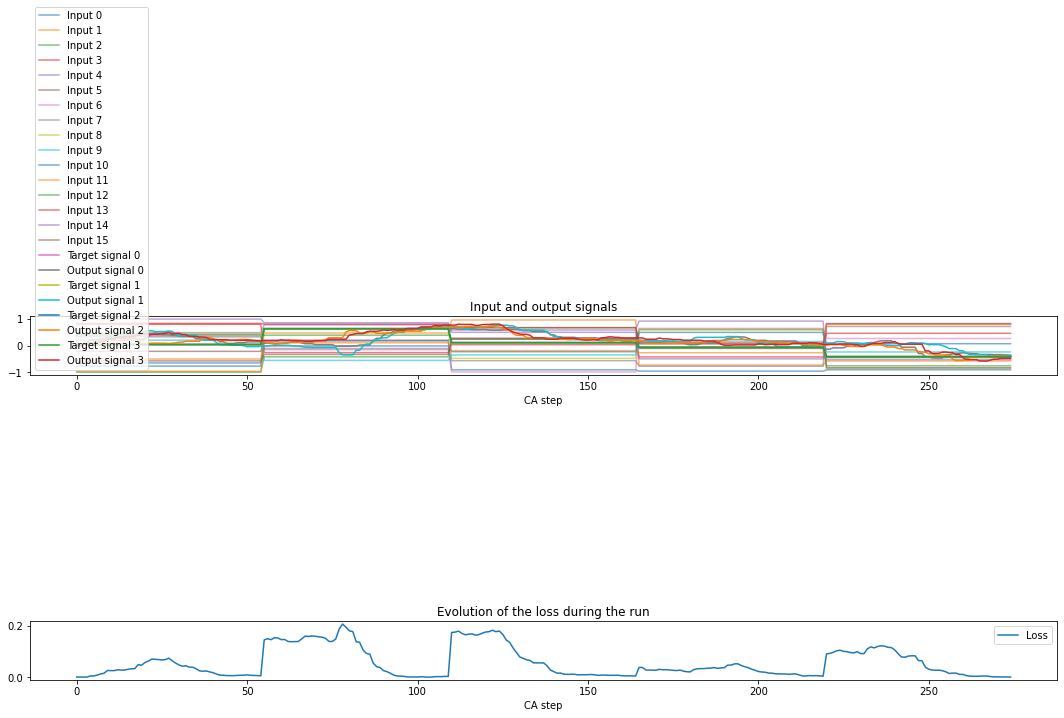

In [30]:
_ = nca.plot_io_signals(55,inputs_b[:5,0,:], targets_b[:5,0,:]) 

In [31]:
nca.neuralCA.dmodel.save_weights("compute_mean_initialisation")

In [34]:
agent = DQNAgent(inp_cell_pos, out_cell_pos)
# define the hyperparameters of the deep-q learning algo.
agent.epsilon = 1.
agent.epsilon_decay = 0.999
#the agent batch size is the number of transitions sampled from the memory at each 
#replay. They will be divided in agent.batch_size/agent.model.batch_size batches 
#for the training of the neural CA

agent.batch_size = 128

lr = 5e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [1000,10000], [lr, lr*0.1, lr*0.001])

# initialize using the previously trained parameters
agent.model.neuralCA.dmodel.load_weights("compute_mean_initialisation")

In [35]:
agent.run()

AttributeError: ignored